In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import regex as re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')


from gensim.models import Word2Vec


import warnings 
warnings.filterwarnings(action = 'ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
reddit = pd.read_csv('reddit_comments.csv', index_col=0)

reddit.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [20]:
reddit.shape

(1010714, 2)

In [21]:
# custom tokenizer function

def tokenizer(series):
    # get values from series
    corpus = series.values
    tokens = [] # empty token list
    
    for document in corpus:
        #removing punctuation
        for punc in string.punctuation:
            document = document.replace(punc, '')
        # removing numbers and setting all documents to lowercase    
        document = re.sub("\d+", "", document).lower()
        # splitting documents and appending tokens list
        tokens.append(document.split(' '))
        
    
        

    return tokens

In [22]:
# setting X and y
X = reddit['comment']
y = reddit['label']

In [23]:
# tokenizing our comments
tokenized_data = tokenizer(X)

In [24]:
# reinstantiating more precise word2vec 
model = Word2Vec(tokenized_data, window=5, min_count=25, workers=4, size=300, max_vocab_size=10000 )
model.train(tokenized_data, total_examples=model.corpus_count, epochs=model.epochs)

(32241029, 52702745)

In [25]:
def sentence(document):
    size = model.vector_size
    word_vec_document = np.zeros(size)
    count = 1
    
    for word in document:
        if word in model:
            count +=1
            word_vec_document += model[word]
    
    word_vec_document = word_vec_document / count
    
    return word_vec_document

In [26]:
# setting vectors to variable
document_vectors = [sentence(doc) for doc in tokenized_data]

In [34]:
X = document_vectors

In [27]:
reddit_samples = pd.read_csv('sample_comments.csv', index_col=0)

In [28]:
X_samp = reddit_samples['comment']
y_samp = reddit_samples['label']

In [29]:
sample_tokens = tokenizer(X_samp)
sample_vectors = [sentence(doc) for doc in sample_tokens]

In [30]:
X_samp = sample_vectors

In [31]:
from sklearn.model_selection import train_test_split
# initial split into rem and test
X_rem, X_test, y_rem, y_test = train_test_split(X_samp, y_samp, test_size=0.25, random_state=42)

In [32]:
# secondary split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [35]:
from sklearn.neural_network import MLPClassifier

neural_network = MLPClassifier(verbose=True, max_iter=100, random_state=42)

neural_network.fit(X, y)

Iteration 1, loss = 0.59243894
Iteration 2, loss = 0.57548462
Iteration 3, loss = 0.56938289
Iteration 4, loss = 0.56532434
Iteration 5, loss = 0.56249961
Iteration 6, loss = 0.56005272
Iteration 7, loss = 0.55813426
Iteration 8, loss = 0.55654253
Iteration 9, loss = 0.55514824
Iteration 10, loss = 0.55380917
Iteration 11, loss = 0.55271587
Iteration 12, loss = 0.55170567
Iteration 13, loss = 0.55080175
Iteration 14, loss = 0.54996557
Iteration 15, loss = 0.54921622
Iteration 16, loss = 0.54843516
Iteration 17, loss = 0.54787004
Iteration 18, loss = 0.54719592
Iteration 19, loss = 0.54665284
Iteration 20, loss = 0.54622983
Iteration 21, loss = 0.54565596
Iteration 22, loss = 0.54526406
Iteration 23, loss = 0.54482931
Iteration 24, loss = 0.54445122
Iteration 25, loss = 0.54393082
Iteration 26, loss = 0.54358698
Iteration 27, loss = 0.54335935
Iteration 28, loss = 0.54305277
Iteration 29, loss = 0.54267447
Iteration 30, loss = 0.54245343
Iteration 31, loss = 0.54217151
Iteration 32, los

MLPClassifier(max_iter=100, random_state=42, verbose=True)

In [36]:
print(f'Train: {neural_network.score(X_train, y_train)}')
print(f'Val: {neural_network.score(X_val, y_val)}')

Train: 0.7348432080263981
Val: 0.7286715353117481


In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [42]:
val_predict = neural_network.predict(X_val)

In [43]:
val_predict[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [44]:
# acc_score = accuracy_score(y_val, val_predict)
# precision = precision_score(y_val, val_predict)
# recall = recall_score(y_val, val_predict)
# f1 = f1_score(y_val, val_predict)

# print('VALIDATION SUMMARY: \n')
# print(f'Accuracy: {round(acc_score, 2)} \n Precision: {round(precision, 2)} \n Recall: {round(recall,2)}  \n F1: {round(f1, 2)}')

In [45]:
report = classification_report(y_val, val_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(report)


               precision    recall  f1-score   support

Non-Sarcastic       0.72      0.75      0.74     23647
    Sarcastic       0.74      0.70      0.72     23731

     accuracy                           0.73     47378
    macro avg       0.73      0.73      0.73     47378
 weighted avg       0.73      0.73      0.73     47378



In [46]:
# reinstantiating more precise word2vec 
new_model = Word2Vec(tokenized_data, window=5, min_count=25, workers=4, size=300, max_vocab_size=25000 )
new_model.train(tokenized_data, total_examples=model.corpus_count, epochs=model.epochs)


(36951469, 52702745)

In [47]:
new_vectors = [sentence(doc) for doc in tokenized_data]
new_X = new_vectors

In [48]:


MLP = MLPClassifier(verbose=True, max_iter=50, random_state=42)

MLP.fit(new_X, y)

Iteration 1, loss = 0.59243894
Iteration 2, loss = 0.57548462
Iteration 3, loss = 0.56938289
Iteration 4, loss = 0.56532434
Iteration 5, loss = 0.56249961
Iteration 6, loss = 0.56005272
Iteration 7, loss = 0.55813426
Iteration 8, loss = 0.55654253
Iteration 9, loss = 0.55514824
Iteration 10, loss = 0.55380917
Iteration 11, loss = 0.55271587
Iteration 12, loss = 0.55170567
Iteration 13, loss = 0.55080175
Iteration 14, loss = 0.54996557
Iteration 15, loss = 0.54921622
Iteration 16, loss = 0.54843516
Iteration 17, loss = 0.54787004
Iteration 18, loss = 0.54719592
Iteration 19, loss = 0.54665284
Iteration 20, loss = 0.54622983
Iteration 21, loss = 0.54565596
Iteration 22, loss = 0.54526406
Iteration 23, loss = 0.54482931
Iteration 24, loss = 0.54445122
Iteration 25, loss = 0.54393082
Iteration 26, loss = 0.54358698
Iteration 27, loss = 0.54335935
Iteration 28, loss = 0.54305277
Iteration 29, loss = 0.54267447
Iteration 30, loss = 0.54245343
Iteration 31, loss = 0.54217151
Iteration 32, los

MLPClassifier(max_iter=100, random_state=42, verbose=True)

In [49]:
print(f'Train: {MLP.score(X_train, y_train)}')
print(f'Val: {MLP.score(X_val, y_val)}')

Train: 0.7348432080263981
Val: 0.7286715353117481


In [50]:
new_val_predict = MLP.predict(X_val)

In [51]:
new_report = classification_report(y_val, new_val_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(new_report)

               precision    recall  f1-score   support

Non-Sarcastic       0.72      0.75      0.74     23647
    Sarcastic       0.74      0.70      0.72     23731

     accuracy                           0.73     47378
    macro avg       0.73      0.73      0.73     47378
 weighted avg       0.73      0.73      0.73     47378



In [55]:
new_probas = MLP.predict_proba(X_val)

In [57]:
new_probas = new_probas[:,1]

In [108]:
# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

precisions = []
recalls = []

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(new_probas > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_threshold)
    recall = recall_score(y_val, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)



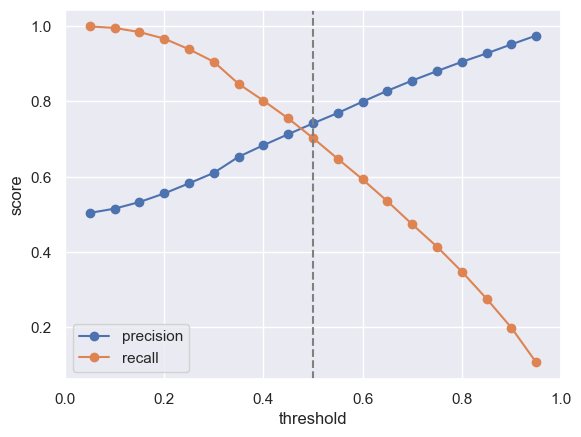

In [109]:
# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.axvline(np.median(thresholds), linestyle='--', color='gray')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()

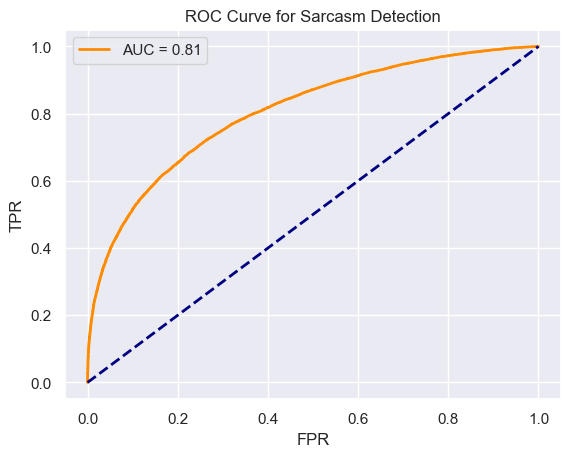

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_val, new_probas)
roc_auc = roc_auc_score(y_val, new_probas)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Sarcasm Detection')
plt.legend(loc="best")
plt.show()



In [110]:
def test_tokenizer(document):
    
    
    # replacing punctuation with empty string
    for punc in string.punctuation:
        document = document.replace(punc, '')
        
        # removing numbers and setting all documents to lowercase    
    document = re.sub("\d+", "", document).lower()
    
        # splitting documents and appending tokens list
    tokens = document.split(' ')
        
    
        

    return tokens

In [120]:
def vectorizer(document):

    tokens = test_tokenizer(document)
    two_d_vec = []
    
    size = model.vector_size
    word_vec_doc = np.zeros(size)
    count = 1
    

    for word in tokens:
        if word in model:
            count +=1
            word_vec_doc += model[word]
    
    word_vec_doc = word_vec_doc / count
    two_d_vec.append(word_vec_doc)
    
    return two_d_vec

In [121]:
document1 = "This is simply a test. Can I call a function within a function?"

vekt_doc = vectorizer(document1)

In [123]:
result = MLP.predict_proba(vekt_doc)[0][1]
print(f'Result: {round(result, 2)}')

Result: 0.13


In [124]:
sentence1 = "Fair and logical."
sentence2 = "He said no. Seems fair and logical to me."
sentence3 = "He said no. Very fair and logical"
sentence4 = "He said no. Very fair and very logical."
sentence5 = "He said no. That's fair and logical."
sentence6 = "He said no. Fair and logical."

In [125]:
doc1 = vectorizer(sentence1)
doc2 = vectorizer(sentence2)
doc3 = vectorizer(sentence3)
doc4 = vectorizer(sentence4)
doc5 = vectorizer(sentence5)
doc6 = vectorizer(sentence6)

In [126]:
proba1 = round(MLP.predict_proba(doc1)[0][1], 2)
proba2 = round(MLP.predict_proba(doc2)[0][1], 2)
proba3 = round(MLP.predict_proba(doc3)[0][1], 2)
proba4 = round(MLP.predict_proba(doc4)[0][1], 2)
proba5 = round(MLP.predict_proba(doc4)[0][1], 2)
proba6 = round(MLP.predict_proba(doc4)[0][1], 2)


In [127]:
print('PROBABILITY SARCASTIC: \n')
print(f'Sentence1: {proba1} \n Sentence2: {proba2} \n Sentence3: {proba3} \n Sentence4: {proba4} \n')
print(f'Sentence5: {proba5} \n Sentence6: {proba6}')

PROBABILITY SARCASTIC: 

Sentence1: 0.34 
 Sentence2: 0.7 
 Sentence3: 0.58 
 Sentence4: 0.49 

Sentence5: 0.49 
 Sentence6: 0.49
